In [5]:
import os
from scipy.optimize import curve_fit
import ROOT
from ROOT import gStyle
import ctypes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def biner(edges,bin_widths,histogram):
    if (len(edges)+1!=len(bin_widths)):
        print("Check edges and bin widths array sizes!")
        return
    
    bins=[]
    first_bin = histogram.GetXaxis().GetBinLowEdge(1)
    print(first_bin)
    last_bin = histogram.GetXaxis().GetBinUpEdge(histogram.GetNbinsX())
    print(last_bin)
    for i in range(0,len(edges)):
        n_spaces = int((edges[i] - first_bin)/bin_widths[i])
        bins = np.concatenate((bins,np.linspace(first_bin,edges[i],n_spaces,endpoint=False)))
        first_bin = edges[i]
        if edges[i]==edges[-1]:
            n_spaces = int((last_bin - edges[i])/bin_widths[i+1])
            bins = np.concatenate((bins,np.linspace(edges[i],last_bin,n_spaces,endpoint=False)))
            bins = np.concatenate((bins,[last_bin]))
    return bins

def normalization(hist_list,norm_bin):
    for hist in hist_list:
        for i in range(1,hist.GetNbinsX()+1):
            value=hist.GetBinContent(i)
            error=hist.GetBinError(i)
            sf=hist.GetBinWidth(i)/norm_bin
            hist.SetBinContent(i,value/sf)
            hist.SetBinError(i,error/sf)
            
def ratio_subtracted_plot(path_to_samples=os.getcwd(),signal_name="Signal",data_name="Data",bg_names=[],histogram_info=None):
    
    MC = ROOT.TFile.Open(path_to_samples+"/"+"MC"+".root","READ")
    Data = ROOT.TFile.Open(path_to_samples+"/"+data_name+".root","READ")
    Signal = ROOT.TFile.Open(path_to_samples+"/"+signal_name+".root","READ")
    
    bg_files_list=[]
    for i in bg_names:
        bg_files_list.append(ROOT.TFile.Open(path_to_samples+"/"+i+".root","READ"))
    
    histogram_name = list(histogram_info.keys())[0]

    mc=MC.Get(histogram_name)
    data=Data.Get(histogram_name)
    signal=Signal.Get(histogram_name)
    
    bg_histograms_list = [i.Get(histogram_name) for i in bg_files_list]
    
    
    mc.SetDirectory(0)
    signal.SetDirectory(0)
    data.SetDirectory(0)
    
    for i in bg_histograms_list:
        i=i.SetDirectory(0)
    
    MC.Close()
    Signal.Close()
    Data.Close()

    [i.Close() for i in bg_files_list]
    
    s=data.GetXaxis().GetBinLowEdge(1)
    e=data.GetXaxis().GetBinUpEdge(data.GetNbinsX())
    

    s=data.GetXaxis().GetBinLowEdge(1)
    e=data.GetXaxis().GetBinUpEdge(data.GetNbinsX())
    rebining=biner(histogram_info[histogram_name][0],histogram_info[histogram_name][1],data)
    nb=len(rebining)-1
    mc=mc.Rebin(nb,"mc",rebining)
    signal=signal.Rebin(nb,"signal",rebining)
    data=data.Rebin(nb,"data",rebining)
    for i in range(0,len(bg_histograms_list)):
        bg_histograms_list[i]=bg_histograms_list[i].Rebin(nb,bg_names[i],rebining)

    if len(histogram_info[histogram_name])>0:
        hist_list=[signal,data,mc]+bg_histograms_list
        normalization(hist_list,histogram_info[histogram_name][2])
        
    data_subtracted=data.Clone()
    for i in bg_histograms_list:
        data_subtracted.Add(i,-1)
        
        
    ratio=data_subtracted.Clone()
    ratio.Divide(signal)

    x_values = []
    y_values = []
    y_uncern = []

    for i in range(1,ratio.GetNbinsX()+1):
        #print("m range = ",ratio.GetBinCenter(i),"SF = ",round(ratio.GetBinContent(i),3),)
        if ratio.GetBinContent(i)>0 or i==1:
            x_values.append(ratio.GetBinLowEdge(i))
            y_values.append(round(ratio.GetBinContent(i),3))
            y_uncern.append(ratio.GetBinError(i))
        else : 
            break
    
    return np.array(x_values),np.array(y_values),np.array(y_uncern)

In [22]:
path_CRa = "/home/diego/HEP/VBF-Analysis/Zll/CRa"
path_CRb = "/home/diego/HEP/VBF-Analysis/Zll/CRb"
path_CRc = "/home/diego/HEP/VBF-Analysis/Zll/CRc"
signal = "Zll_MG"

histo={
"mass_jj":[[1500,3000],[250,500,1000],250],
}

CRa_axis,CRa_y,CRa_error=ratio_subtracted_plot(path_to_samples=path_CRa,signal_name=signal,data_name="Data",bg_names=["Signal_Sherpa","VV","Wjets","ttbar","singletop"],histogram_info=histo)
CRb_axis,CRb_y,CRb_error=ratio_subtracted_plot(path_to_samples=path_CRb,signal_name=signal,data_name="Data",bg_names=["Signal_Sherpa","VV","Wjets","ttbar","singletop"],histogram_info=histo)
CRc_axis,CRc_y,CRc_error=ratio_subtracted_plot(path_to_samples=path_CRc,signal_name=signal,data_name="Data",bg_names=["Signal_Sherpa","VV","Wjets","ttbar","singletop"],histogram_info=histo)

0.0
5000.0
0.0
5000.0
0.0
5000.0


In [23]:
CRa_axis

array([   0.,  250.,  500.,  750., 1000., 1250., 1500., 2000., 2500.,
       3000., 4000.])

In [24]:
def parabolic_shape(mjj,a,b,c):
    return a*mjj*mjj+b*mjj+c

def chi_square2(model, slope, level,offset, x,y,uncer):
    chi=0
    for i in range(0,len(x)):
        chi+=((y[i]-model(x[i],slope,level,offset))**2)/(uncer[i]**2)
        #print(x[i])
        #print(((y[i]-model(x[i],slope,level))**2)/(uncer[i]**2))
    return (chi/(len(x)-3))

CRa_fit, CRa_cov = curve_fit(parabolic_shape, CRa_axis[1:], CRa_y[1:],sigma=CRa_error[1:])
CRb_fit, CRb_cov = curve_fit(parabolic_shape, CRb_axis[1:], CRb_y[1:],sigma=CRb_error[1:])
CRc_fit, CRc_cov = curve_fit(parabolic_shape, CRc_axis[1:], CRc_y[1:],sigma=CRc_error[1:])

In [25]:
def model_uncern(covariance_matrix,x):
    sigma_a = covariance_matrix[0][0]
    sigma_b = covariance_matrix[1][1]
    sigma_c = covariance_matrix[2][2]
    
    cov_ab = covariance_matrix[0][1]
    cov_ac = covariance_matrix[0][2]
    cov_bc = covariance_matrix[1][2]
    
    diagonal_term = sigma_a*x**4 + sigma_b*x**2 + sigma_c
    no_diagonal_term = 2*cov_ab*x**3 + 2*cov_ac*x**2 + 2*cov_bc*x
    
    return np.sqrt(diagonal_term+no_diagonal_term)

model_uncer = np.vectorize(model_uncern)
parabolic_shape = np.vectorize(parabolic_shape)

3.2649432915307304
0.7942683377266313


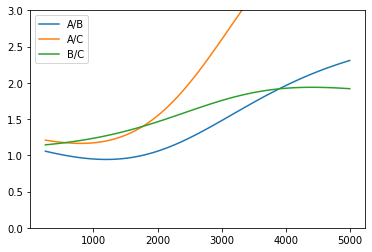

In [26]:
x=np.linspace(250,5000,100)

r_ab=parabolic_shape(x,CRa_fit[0],CRa_fit[1],CRa_fit[2])/parabolic_shape(x,CRb_fit[0],CRb_fit[1],CRb_fit[2])
r_ab_error=r_ab*np.sqrt((model_uncern(CRa_cov,x)/parabolic_shape(x,CRa_fit[0],CRa_fit[1],CRa_fit[2]))**2
                        +(model_uncern(CRb_cov,x)/parabolic_shape(x,CRb_fit[0],CRb_fit[1],CRb_fit[2])**2))

r_ac=parabolic_shape(x,CRa_fit[0],CRa_fit[1],CRa_fit[2])/parabolic_shape(x,CRc_fit[0],CRc_fit[1],CRc_fit[2])
r_ac_error=r_ac*np.sqrt((model_uncern(CRa_cov,x)/parabolic_shape(x,CRa_fit[0],CRa_fit[1],CRa_fit[2]))**2
                        +(model_uncern(CRc_cov,x)/parabolic_shape(x,CRc_fit[0],CRc_fit[1],CRc_fit[2])**2))

r_bc=parabolic_shape(x,CRb_fit[0],CRb_fit[1],CRb_fit[2])/parabolic_shape(x,CRc_fit[0],CRc_fit[1],CRc_fit[2])
r_bc_error=r_bc*np.sqrt((model_uncern(CRb_cov,x)/parabolic_shape(x,CRb_fit[0],CRb_fit[1],CRb_fit[2]))**2
                        +(model_uncern(CRc_cov,x)/parabolic_shape(x,CRc_fit[0],CRc_fit[1],CRc_fit[2])**2))



plt.plot(x,r_ab)
plt.plot(x,r_ac)
plt.plot(x,r_bc)
plt.legend(["A/B","A/C","B/C"])
plt.ylim(0,3)


print(r_ac.max()-r_ac.min())
print(r_bc.max()-r_bc.min())

In [27]:
x=CRa_axis
CRa_predy,CRa_prederror = parabolic_shape(x,CRa_fit[0],CRa_fit[1],CRa_fit[2]),model_uncern(CRa_cov,x)
CRb_predy,CRb_prederror = parabolic_shape(x,CRb_fit[0],CRb_fit[1],CRb_fit[2]),model_uncern(CRb_cov,x)
CRc_predy,CRc_prederror = parabolic_shape(x,CRc_fit[0],CRc_fit[1],CRc_fit[2]),model_uncern(CRc_cov,x)

SR_y = CRa_predy*CRc_predy/CRb_predy
SR_error = SR_y*np.sqrt((CRa_prederror/CRa_predy)**2+(CRb_prederror/CRb_predy)**2+(CRc_prederror/CRc_predy)**2)



SF =  [0.92915228 0.8049047  0.70033162 0.61513934 0.54877327 0.50038677
 0.46885328 0.45094266 0.48463207 0.56385869 0.86745058]
SF error =  [0.04590188 0.02378114 0.01545945 0.01828843 0.02243425 0.02629707
 0.03253002 0.06470528 0.13604878 0.26045386 0.71321048]


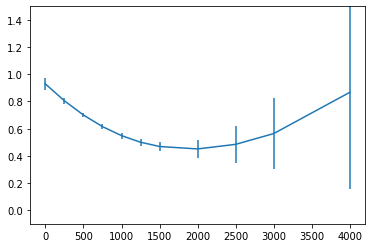

In [28]:
plt.errorbar(x,SR_y,yerr=SR_error)
plt.ylim([-.1,1.5])

print("SF = ",SR_y)
print("SF error = ",SR_error)

In [29]:
def parabolic_shape(mjj,a,b,c):
    return a*mjj*mjj+b*mjj+c
SR_fit, SR_cov = curve_fit(parabolic_shape, x, SR_y,sigma=SR_error)

def fit_results(params,covariance,params_names):
    result = []
    for i in range(0,len(params)):
        result.append(params[i])
        result.append(np.sqrt(covariance[i][i]))
        
    column_name = []
    for i in params_names:
        column_name.append(i)
        column_name.append('Sigma '+i)
        
    df = pd.DataFrame (result,index=column_name)
    return df.T

fit_results(SR_fit,SR_cov,['a','b','c'])

,a,Sigma a,b,Sigma b,c,Sigma c
0,1.333644e-07,4.091666e-09,-0.000505,0.000008,0.92086,0.003857


In [2]:
import ROOT as r
import os

%run 'Plotter.ipynb'

def Unpack_Histo(histogram_file):
    bin_content = []
    bin_content_uncer =[]
    for i in range(2,histogram_file.GetNbinsX()+1):
        bin_content.append(histogram_file.GetBinContent(i))
        bin_content_uncer.append(histogram_file.GetBinError(i))
    return np.array(bin_content),np.array(bin_content_uncer)

In [4]:
path="../Zll/"
qcd_sample="Zll_MG.root"
vbf_sample="Signa_Sherpa.root"

histo={
"mass_jj":[[1500,3000],[250,500,1000],250],
}

regions=["CRa/","CRb/","CRc/"]#[["CRb/","CRa/"],["CRb/","CRc/"]]#
colors=[r.kBlue,r.kRed,r.kGreen]

r.TH1.AddDirectory(r.kFALSE)
Canvas = ROOT.TCanvas("canvas")
Canvas.cd()

legend = ROOT . TLegend (0.45 ,0.80 ,0.85 ,0.95)

c=0
for cr in regions:
    CR_file=r.TFile.Open(path+cr+qcd_sample)
    SR_file=r.TFile.Open(path+"SR/"+qcd_sample)
    
    #CR_file_data=r.TFile.Open(path+cr+"Data.root")
    #SR_file_data=r.TFile.Open(path+"SR/"+"Data.root")
    
    #CR_file_signal=r.TFile.Open(path+cr+vbf_sample)
    #SR_file_signal=r.TFile.Open(path+"SR/"+vbf_sample)
    
    CR=CR_file.Get("mass_jj")
    SR=SR_file.Get("mass_jj")
    
    #CR_data=CR_file_data.Get("mass_jj")
    #SR_data=SR_file_data.Get("mass_jj")
    
    #CR_signal=CR_file_signal.Get("mass_jj")
    #SR_signal=SR_file_signal.Get("mass_jj")
    
    #CR_data.Add(CR_signal,-1)
    #SR_data.Add(SR_signal,-1)
    
    rebining=biner(histo["mass_jj"][0],histo["mass_jj"][1],SR)
    nb=len(rebining)-1
    CR=CR.Rebin(nb,"CR",rebining)
    SR=SR.Rebin(nb,"SR",rebining)
    
    CR.Scale(1/CR.Integral(1,-1,"width"))
    SR.Scale(1/SR.Integral(1,-1,"width"))
    
    #CR_data=CR_data.Rebin(nb,"CR",rebining)
    #SR_data=SR_data.Rebin(nb,"SR",rebining)
    
    #CR.Divide(CR_data)
    #SR.Divide(SR_data)
    
    SR.Divide(CR)
    SR.SetTitle("SR/CRi")
    #SR.SetTitle("CRj/CRi")
    SR.SetLineColor(colors[c])
    
    
    print(Unpack_Histo(SR))
    
    
    SR.Fit("pol1","F","same",0,5000)
    
    c+=1
    SR.GetYaxis().SetRangeUser(0,3)
    
    legend.AddEntry(SR,"SR/"+cr[0])
    #legend.AddEntry(SR,cr[1][:-1]+"/"+cr[0][:-1])
    
    SR.Draw("same")
  
    
legend.Draw()
Canvas.Print("Zll_CRi-SR.pdf") 
    
    

0.0
5000.0
(array([1.36794531, 1.09241414, 0.89026988, 0.78009623, 0.62210596,
       0.62110871, 0.5857293 , 0.7745406 , 0.59778947, 0.68026555]), array([0.02012357, 0.01491411, 0.01571727, 0.01953574, 0.06264988,
       0.02268164, 0.03665924, 0.07321661, 0.07261506, 0.27062507]))
0.0
5000.0
(array([1.05275631, 0.91104877, 0.89794254, 0.97367442, 0.92058611,
       1.26409686, 1.63589966, 1.73156583, 2.08786511, 9.03475952]), array([0.01835195, 0.01530193, 0.02149997, 0.03216338, 0.05387353,
       0.07043847, 0.2092223 , 0.45580032, 0.54501208, 5.48198209]))
0.0
5000.0
(array([ 0.83782703,  0.94988137,  1.07373536,  1.27226925,  1.30644107,
        1.6539005 ,  2.41354036,  3.96563172,  4.55003881, 14.47130203]), array([0.00914283, 0.01150731, 0.01728026, 0.03127507, 0.04845319,
       0.07180173, 0.18259241, 0.47656865, 0.81845578, 4.41446637]))
 FCN=303.898 FROM MIGRAD    STATUS=CONVERGED      31 CALLS          32 TOTAL
                     EDM=3.52076e-21    STRATEGY= 1      ERRO

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file Zll_CRi-SR.pdf has been created
